#1. Surface Crack Detection 데이터셋
Surface Crack Detection 데이터셋은 콘크리트 표면에서 균열을 자동으로 탐지하기 위한 학습 데이터를 제공합니다. 이 데이터셋은 주로 다양한 콘크리트 표면 이미지를 포함하고 있으며, 각 이미지는 균열이 포함된 부분과 그렇지 않은 부분으로 구분됩니다. 이러한 데이터셋은 컴퓨터 비전 모델, 특히 Convolutional Neural Network(CNN) 등의 딥러닝 모델을 훈련시키는 데 사용되며, 균열 탐지 및 구조물의 상태 평가에 중요한 역할을 합니다. 다양한 환경과 조건을 반영한 이미지를 제공하여, 실제 적용에서 발생할 수 있는 다양한 상황에 대한 모델의 일반화 능력을 높이는 데 도움을 줍니다.  

https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

In [1]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download arunrk7/surface-crack-detection

Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
License(s): copyright-authors
100% 232M/233M [00:00<00:00, 800MB/s] 
100% 233M/233M [00:00<00:00, 842MB/s]


In [3]:
!unzip -q surface-crack-detection.zip

In [4]:
import os
import shutil
import random
import torch
import glob
import numpy as np
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
# train, val, test 폴더 및 하위 폴더 생성
dataset_structure = ['train/negative', 'train/positive',
                     'val/negative', 'val/positive',
                     'test/negative', 'test/positive']

for folder in dataset_structure:
    os.makedirs(folder, exist_ok=True)

# 데이터 분할 및 복사
categories = ['Negative', 'Positive']

for category in categories:
    files = os.listdir(category) # 파일을 리스트로 가져와서 이름으로 저장
    random.shuffle(files) # 순서를 랜덤하게 셔플
    num_files = len(files) # 총 파일이 몇 개인지 계산
    train_split = int(num_files * 0.6)
    val_split = int(num_files * 0.2)

    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    target_category = category.lower()

    for file in train_files:
        shutil.copy(os.path.join(category, file), f'train/{target_category}/')
    for file in val_files:
        shutil.copy(os.path.join(category, file), f'val/{target_category}/')
    for file in test_files:
        shutil.copy(os.path.join(category, file), f'test/{target_category}/')

print("데이터 분할 및 복사 완료!")

데이터 분할 및 복사 완료!


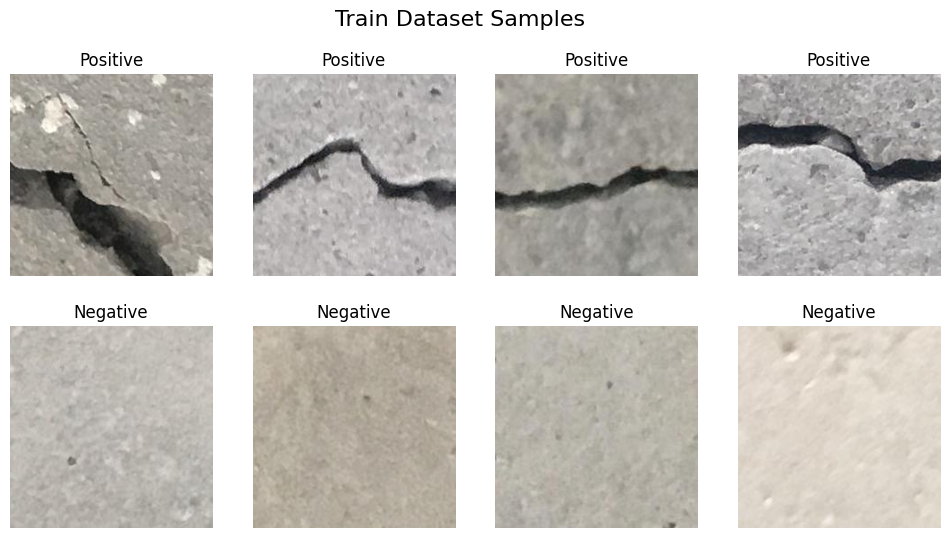

In [7]:
# 폴더 경로 설정
train_positive_dir = "train/positive"
train_negative_dir = "train/negative"

# 각 폴더에서 4개씩 샘플링-> 파일의 이름만 갖고옴
positive_files = random.sample(os.listdir(train_positive_dir), 4)
negative_files = random.sample(os.listdir(train_negative_dir), 4)

# 파일 경로 리스트 생성 -> 경로까지 합쳐져서 파일을 갖고 오게 됨
positive_paths = [os.path.join(train_positive_dir, file) for file in positive_files]
negative_paths = [os.path.join(train_negative_dir, file) for file in negative_files]

# 이미지 시각화
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Train Dataset Samples", fontsize=16)

for i, file_path in enumerate(positive_paths):
    image = Image.open(file_path)
    axes[0, i].imshow(image)
    axes[0, i].axis("off")
    axes[0, i].set_title("Positive")

for i, file_path in enumerate(negative_paths):
    image = Image.open(file_path)
    axes[1, i].imshow(image)
    axes[1, i].axis("off")
    axes[1, i].set_title("Negative")
plt.show()

In [8]:
# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # 정규화 (ReLU가 작동해야하기 때문에 정규화를 -1 ~ 1 사이의 데이터로 변환)
    # (0.5, 0.5, 0.5): 이렇게 3개를 하는 이유? RGB 값 3개를 다 해줘야하기 때문
])

# negative 폴더가 0, positive 폴더가 1로 자동 라벨링
# 데이터셋 로드
train_dataset = ImageFolder('/content/train', transform=transform)
val_dataset = ImageFolder('/content/val', transform=transform)

In [9]:
print(len(train_dataset))
print(len(val_dataset))

24000
8000


In [10]:
# 사용할 데이터셋의 비율 (예: 10%만 사용)
# 너무 오래 걸려서..! 일단 학습에서는 10%만 쓸게요!
subset_ratio = 0.1

# 전체 데이터셋 크기 확인
total_train_size = len(train_dataset)
total_val_size = len(val_dataset)

# 선택할 샘플 수 계산
train_subset_size = int(total_train_size * subset_ratio)
val_subset_size = int(total_val_size * subset_ratio)

# 랜덤하게 샘플 선택 (1 사이즈에서 2만큼 랜덤하게 추출해서 리스트형으로 저장해줌)
train_indices = np.random.choice(total_train_size, train_subset_size, replace=False)
val_indices = np.random.choice(total_val_size, val_subset_size, replace=False)

# Subset을 사용하여 데이터셋 크기 줄이기 :
# 기존 데이터셋에서 원하는 인덱스만 골라 새로운 "부분 집합" 데이터셋을 만드는 래퍼 클래스
# indices에 있는 index만 뽑아서 dataset에서 찾아서 새롭게 담는다.
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

# 이렇게 과정을 분리하는 이유? 재현성, 투형성, 효율성 확보를 위해

# 데이터셋 크기 출력
print(f"Train dataset size after reduction: {len(train_dataset)}")
print(f"Validation dataset size after reduction: {len(val_dataset)}")

# DataLoader 생성
# num_workers=4, pin_memory=True : cpu 몇개?, 메모리 최대로 쓸 건지?
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Train dataset size after reduction: 2400
Validation dataset size after reduction: 800


### 한 줄 요약 비유
“도서관에서 1,000권 책 중 100권만 무작위로 골라 읽고 싶다면,

‘전체 책 수’를 알아야 하고,

‘어떤 책 번호’를 뽑을지를 결정한 뒤,

그 책 번호 목록으로만 책장을 들여다보는 방식**”이 필요한 것과 같습니다.

이 과정을 분리해 두면

“몇 권을 뽑을지(비율 계산)”,

“어떤 권을 뽑을지(랜덤 인덱스 계산)”,

“뽑은 권만 보여 주기(Subset 래핑)”

…각 단계에서 재현성, 투명성, 효율성을 확보할 수 있게 되는 거죠.

# 2. vgg19
VGG19는 2014년 Visual Geometry Group(VGG)에서 개발한 합성곱 신경망(CNN) 모델로, ImageNet 대회(ILSVRC-2014)에서 우수한 성능을 보이며 널리 알려졌습니다. 총 19개 층(16개의 합성곱 층 + 3개의 완전연결 층)으로 구성되었으며, 모든 합성곱 층에서 3x3 필터를 사용하고, 최대 풀링을 통한 다운샘플링을 적용하여 깊은 계층에서도 효과적으로 특징을 학습할 수 있도록 설계되었습니다. VGG19는 깊은 구조를 통해 고해상도 이미지의 복잡한 패턴을 학습하는 데 강점이 있으며, 이미지 분류, 객체 검출, 스타일 트랜스퍼 등 다양한 컴퓨터 비전 작업에서 널리 활용됩니다.

[관련 논문 링크]('https://arxiv.org/pdf/2412.20345')

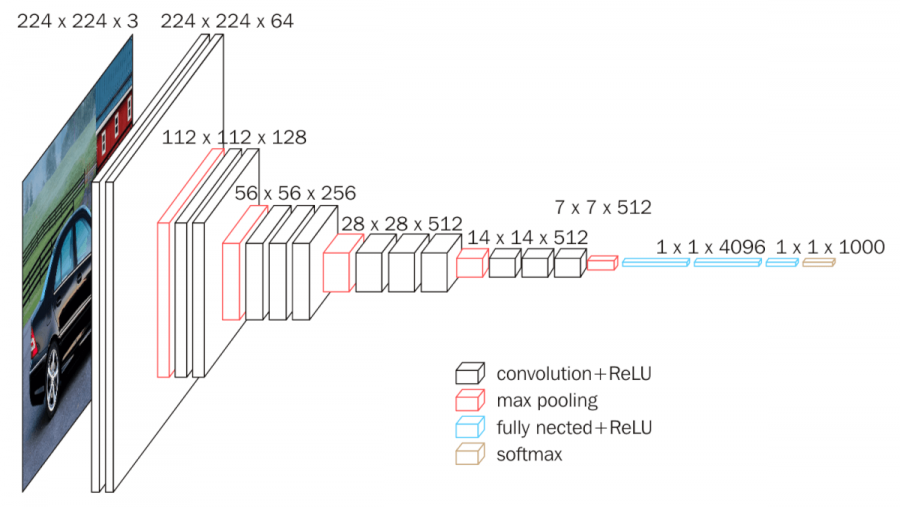

- 알렉스넷보다 훨씬 층이 깊다.
- 복잡할수록 연산량이 많다.
- 쌍으로 여러 층이 쌓여 있다,


In [11]:
# VGG 모델 로드 및 네트워크 구조 확인
net = vgg19(weights=VGG19_Weights.IMAGENET1K_V1) # 이 모델을 쓰면 이 모델의 가중치를 갖다 써야함.
net

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 135MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
# 불러온 모델 프리징 (모든 파라미터 고정하기)
# 모든 가중치가 학습되지 않도록 고정시켜주기

for param in net.parameters():
    param.requires_grad = False

In [13]:
# 알렉스넷에서는 모델의 classifier에 접근해서 수정해줬었음.
# 여기선 다르게 해보기
# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True

In [14]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

1. 장치 설정: GPU가 있으면 GPU를, 없으면 CPU를 사용하도록 네트워크와 데이터를 옮깁니다.

2. 옵티마이저 선택: 함수 호출 시 문자열('SGD', 'Adam', 'RAdam')에 따라 최적화 알고리즘을 세팅합니다.

3. 학습 루프:

> 매 미니배치마다 순전파→손실 계산→역전파→파라미터 업데이트 과정을 수행해 모델을 학습합니다.

> 한 에포크가 끝나면 평균 학습 손실을 기록합니다.

4. 검증 루프:

> 에포크가 끝난 뒤 모델을 평가 모드로 전환하고, 검증 데이터로 순전파만 수행해 검증 손실과 정확도를 계산·기록합니다.

5. 결과 반환:

> 에포크별 학습 손실(train_losses), 검증 손실(val_losses), 검증 정확도(val_accuracies)를 반환하여, 이후 그래프로 그리거나 비교 분석에 활용할 수 있습니다.

### 언제 Adam과 RAdam을 사용할까?

- Adam: 기본적으로 가장 많이 사용되는 최적화 알고리즘이며, 다양한 모델에서 잘 동작함.
- RAdam: 학습 초반에 불안정한 동작을 보이는 경우 (예: 작은 배치 크기, 불안정한 손실 함수)에는 Adam보다 RAdam이 더 좋은 선택.  

즉, Adam을 먼저 사용하고, 학습이 불안정하면 RAdam을 고려하는 것이 일반적인 전략입니다.

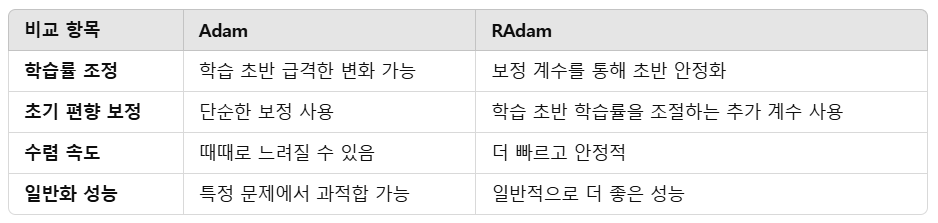

In [15]:
import torch.optim as optim   # PyTorch 최적화 도구(optimizer) 모듈을 불러옵니다.

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # GPU가 사용 가능하면 'cuda', 아니면 CPU('cpu')를 사용하도록 장치를 설정합니다.
    net.to(device)
    # 신경망(net)을 위에서 정한 장치(GPU/CPU)로 옮겨 연산이 해당 장치에서 이뤄지게 합니다.

    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        # 확률적 경사하강법(SGD) 옵티마이저를 learning rate=0.001, momentum=0.9로 생성
        # momentum=0.9는 SGD(확률적 경사하강법)에 관성을 부여하는 하이퍼파라미터
        # 지난 업데이트 방향을 90% 기억해서, 관성(inertia)을 활용해 파라미터를 더 빠르고 안정적으로 움직이게
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
        # Adam 옵티마이저를 learning rate=0.001, 베타값 (0.9, 0.999)로 생성
        # betas=(0.9, 0.999) : 평균과 분산값
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
        # RAdam(Range-aware Adam) 옵티마이저를 같은 하이퍼파라미터로 생성
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
        # 지원하지 않는 optimizer_name이 들어오면 에러를 발생시킵니다.

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []      # 매 에포크(epoch)마다의 학습 손실을 저장
    val_losses = []        # 매 에포크마다의 검증(Validation) 손실을 저장
    val_accuracies = []    # 매 에포크마다의 검증 정확도를 저장

    for epoch in range(num_epochs):
        # 지정한 에포크 수만큼 학습을 반복합니다.
        net.train()  # 모델을 '학습 모드'로 전환 (Dropout, BatchNorm 등이 학습 설정으로 동작)
        running_loss = 0.0  # 한 에포크 동안 누적된 손실 값을 저장할 변수

        for i, data in enumerate(train_loader):
            # 학습용 DataLoader에서 미니배치 단위로 데이터를 꺼냅니다.
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # 입력과 정답 레이블을 GPU/CPU 장치로 옮깁니다.

            optimizer.zero_grad()
            # 이전 배치에서 계산된 기울기를 초기화합니다.
            outputs = net(inputs)
            # 현재 배치 입력을 신경망에 넣어 예측값(outputs)을 계산
            loss = criterion(outputs, labels)
            # 예측값과 실제값을 비교해 손실(loss)을 계산
            loss.backward()
            # 손실을 기반으로 모델 파라미터의 기울기를 자동으로 계산
            optimizer.step()
            # 계산된 기울기를 이용해 파라미터를 한 스텝 업데이트
            running_loss += loss.item()
            # 이번 배치의 손실 값을 누적

        # ────────────────────────────────────────────────────────────────────
        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실과 정확도 계산
        val_loss = 0.0
        net.eval()  # 모델을 '평가 모드'로 전환 (Dropout, BatchNorm 등이 추론 설정으로 동작)
        correct = 0
        total = 0
        with torch.no_grad():
            # 평가 시에는 기울기를 계산하지 않도록 설정하여 메모리 절약
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                # 예측값(outputs) 중 가장 높은 확률을 갖는 클래스 인덱스를 꺼냅니다.
                total += labels.size(0)
                # 전체 샘플 수 누적
                correct += (predicted == labels).sum().item()
                # 정답과 일치하는 예측 수 누적
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # 검증 배치 손실 누적

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        # 검증 정확도를 백분율로 계산
        val_accuracies.append(val_accuracy)

        print(
            f'[{optimizer_name}] Epoch {epoch + 1}, '
            f'Train Loss: {train_loss:.6f}, '
            f'Val Loss: {val_loss:.6f}, '
            f'Validation Accuracy: {val_accuracy:.2f}%',
            flush=True # 버퍼에 쌓여있는 값 그대로 바로바로 찍어달라는 것, 강제로 출력 버퍼 비워주는 것 별 의미 없음
        )
        # 매 에포크마다 학습 손실, 검증 손실, 검증 정확도를 화면에 출력

    return train_losses, val_losses, val_accuracies
    # 학습이 끝난 후, 에포크별 학습 손실/검증 손실/검증 정확도 리스트를 반환


In [17]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', net, train_loader, val_loader, criterion)

[SGD] Epoch 1, Train Loss: 0.055785, Val Loss: 0.045923, Validation Accuracy: 98.62%
[SGD] Epoch 2, Train Loss: 0.055978, Val Loss: 0.041913, Validation Accuracy: 98.62%
[SGD] Epoch 3, Train Loss: 0.053428, Val Loss: 0.043248, Validation Accuracy: 98.62%
[SGD] Epoch 4, Train Loss: 0.050556, Val Loss: 0.040524, Validation Accuracy: 98.62%
[SGD] Epoch 5, Train Loss: 0.050042, Val Loss: 0.041887, Validation Accuracy: 98.62%
[SGD] Epoch 6, Train Loss: 0.052793, Val Loss: 0.039447, Validation Accuracy: 98.75%
[SGD] Epoch 7, Train Loss: 0.053996, Val Loss: 0.035484, Validation Accuracy: 99.12%
[SGD] Epoch 8, Train Loss: 0.049040, Val Loss: 0.039450, Validation Accuracy: 98.75%
[SGD] Epoch 9, Train Loss: 0.052208, Val Loss: 0.037977, Validation Accuracy: 98.75%
[SGD] Epoch 10, Train Loss: 0.047584, Val Loss: 0.038025, Validation Accuracy: 98.75%
[SGD] Epoch 11, Train Loss: 0.048169, Val Loss: 0.032803, Validation Accuracy: 99.12%
[SGD] Epoch 12, Train Loss: 0.049927, Val Loss: 0.035708, Valid

In [ ]:
# 초기화
net = models.vgg19(pretrained=True)
# 파라미터 프리징
for param in net.parameters():
    param.requires_grad = False
net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True

In [19]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.045034, Val Loss: 0.045460, Validation Accuracy: 98.50%
[Adam] Epoch 2, Train Loss: 0.043959, Val Loss: 0.026990, Validation Accuracy: 99.12%
[Adam] Epoch 3, Train Loss: 0.049085, Val Loss: 0.029394, Validation Accuracy: 99.25%
[Adam] Epoch 4, Train Loss: 0.043675, Val Loss: 0.022422, Validation Accuracy: 99.12%
[Adam] Epoch 5, Train Loss: 0.036380, Val Loss: 0.019915, Validation Accuracy: 99.25%
[Adam] Epoch 6, Train Loss: 0.040016, Val Loss: 0.024953, Validation Accuracy: 99.00%
[Adam] Epoch 7, Train Loss: 0.033643, Val Loss: 0.020548, Validation Accuracy: 99.00%
[Adam] Epoch 8, Train Loss: 0.033809, Val Loss: 0.018932, Validation Accuracy: 99.38%
[Adam] Epoch 9, Train Loss: 0.038017, Val Loss: 0.024047, Validation Accuracy: 99.00%
[Adam] Epoch 10, Train Loss: 0.032603, Val Loss: 0.016483, Validation Accuracy: 99.62%
[Adam] Epoch 11, Train Loss: 0.031335, Val Loss: 0.022848, Validation Accuracy: 99.12%
[Adam] Epoch 12, Train Loss: 0.037449, Val Loss: 0.0

In [20]:
# 초기화
net = models.vgg19(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True

train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[RAdam] Epoch 1, Train Loss: 0.490731, Val Loss: 0.295116, Validation Accuracy: 95.88%
[RAdam] Epoch 2, Train Loss: 0.213720, Val Loss: 0.159320, Validation Accuracy: 96.25%
[RAdam] Epoch 3, Train Loss: 0.133857, Val Loss: 0.108286, Validation Accuracy: 97.62%
[RAdam] Epoch 4, Train Loss: 0.100203, Val Loss: 0.084699, Validation Accuracy: 98.12%
[RAdam] Epoch 5, Train Loss: 0.084354, Val Loss: 0.071229, Validation Accuracy: 98.25%
[RAdam] Epoch 6, Train Loss: 0.074191, Val Loss: 0.060120, Validation Accuracy: 98.38%
[RAdam] Epoch 7, Train Loss: 0.065232, Val Loss: 0.058625, Validation Accuracy: 98.50%
[RAdam] Epoch 8, Train Loss: 0.058122, Val Loss: 0.048347, Validation Accuracy: 98.62%
[RAdam] Epoch 9, Train Loss: 0.062185, Val Loss: 0.047549, Validation Accuracy: 98.62%
[RAdam] Epoch 10, Train Loss: 0.050426, Val Loss: 0.040771, Validation Accuracy: 98.75%
[RAdam] Epoch 11, Train Loss: 0.051204, Val Loss: 0.038621, Validation Accuracy: 98.88%
[RAdam] Epoch 12, Train Loss: 0.049873, V

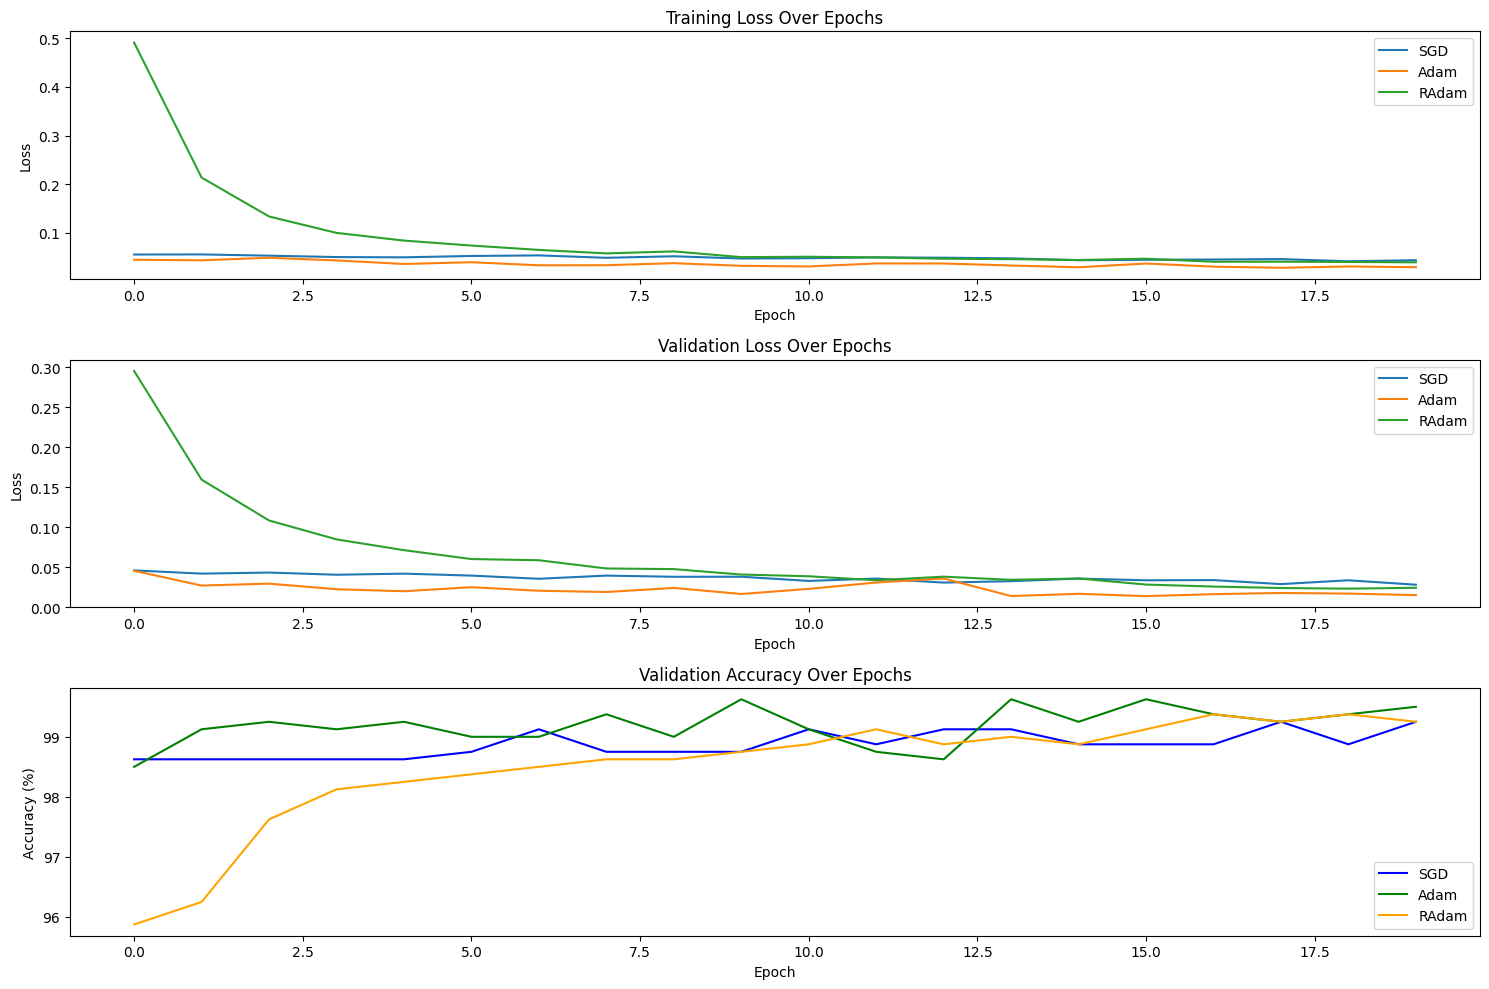

In [21]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(val_accuracies_RAdam, label='RAdam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

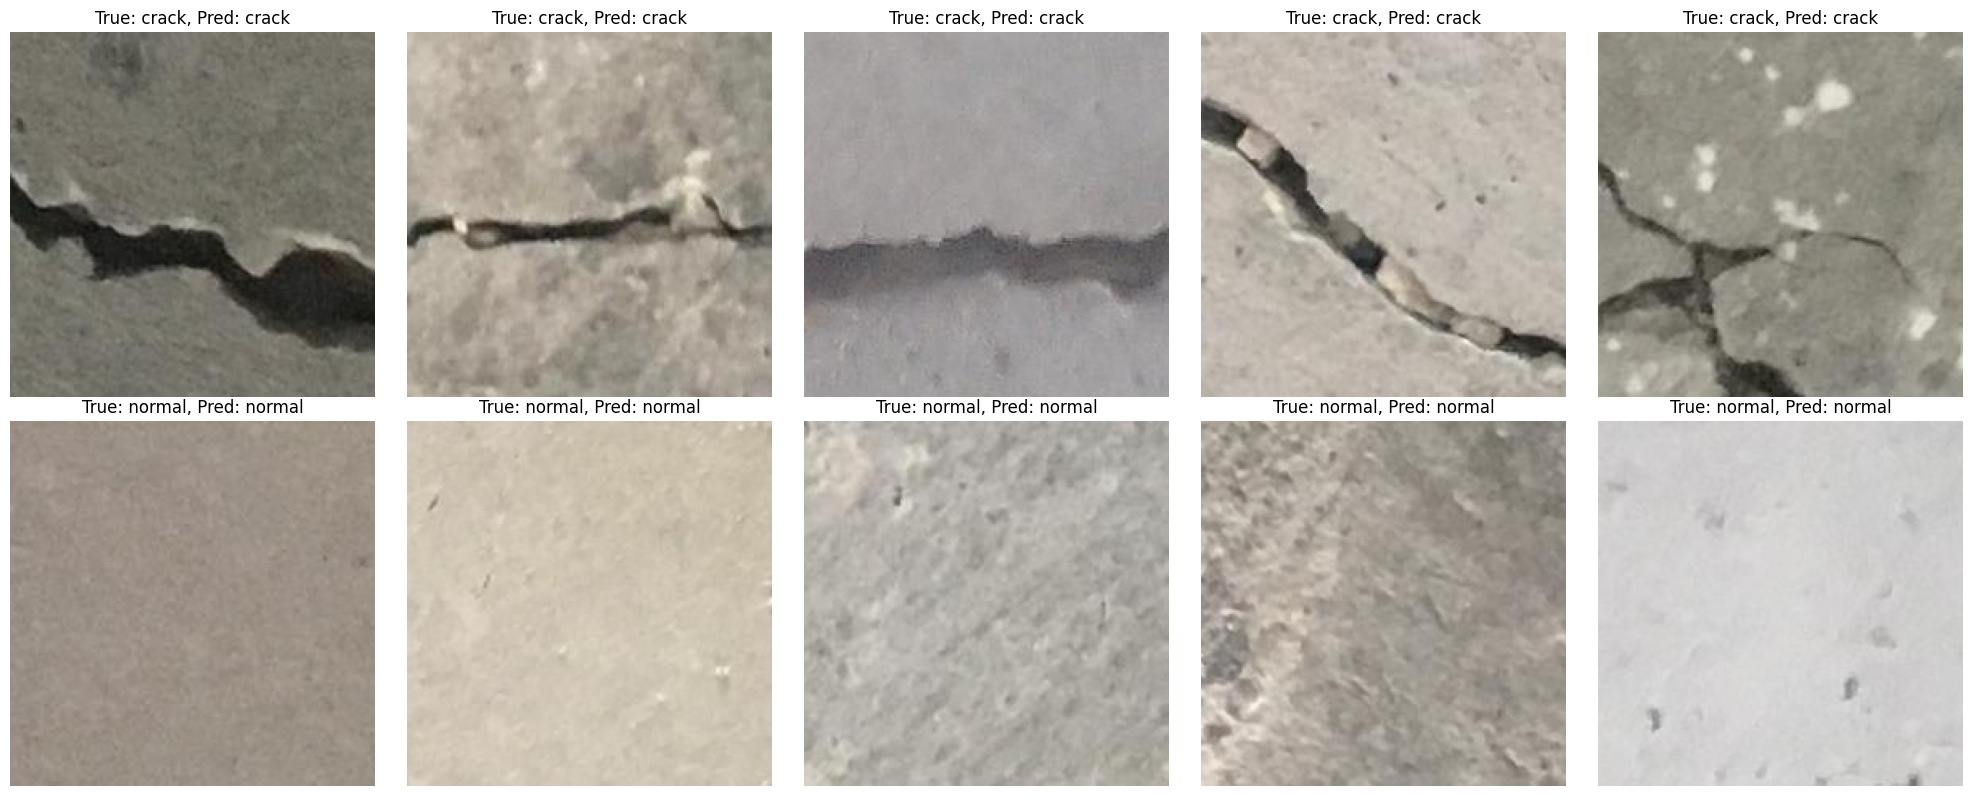

In [23]:
# 클래스별 폴더 경로
class_folders = {
    'crack': '/content/test/positive',
    'normal': '/content/test/negative'
}

# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        image = image.to(device)

        net.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'normal' if predicted.item() == 0 else 'crack'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()